In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

<b> Question 1: <u>Modeling volatility Find data for historical prices for any publicly traded equity. </u></b>

To ensure the length of data, use daily data for at least 3 years. Fit the historical data to

1. Geometric Brownian motion
2. Any non-constant volatility model

Find market data for option prices for this stock. Use option prices to

3. Show volatility smile
4. Construct term structure of volatility
5. Plot the volatility surface, as a function of time to maturity and moneyness.

In [2]:
spy = yf.Ticker('SPY')
df = spy.history(period="5y")
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2023-10-20 00:00:00-04:00,425.980011,426.540009,421.079987,421.190002,123845800,0.0,0.0,0.0
2023-10-23 00:00:00-04:00,419.609985,424.450012,417.799988,420.459991,92035100,0.0,0.0,0.0
2023-10-24 00:00:00-04:00,422.649994,424.820007,420.739990,423.630005,78564200,0.0,0.0,0.0
2023-10-25 00:00:00-04:00,421.890015,421.920013,417.019989,417.549988,93891000,0.0,0.0,0.0
2023-10-26 00:00:00-04:00,416.450012,417.325012,414.250000,414.670013,31913525,0.0,0.0,0.0


<b> 1. <u>Geometric Brownian motion </b>

$\frac{lnS(t_i)-lnS(t_{i-1})}{\sqrt{\Delta t}}= (\mu-\frac{1}{2}\sigma^2)\sqrt{\Delta t}+\sigma\frac{B(t_i)-B(t_{i-1})}{\sqrt{\Delta t}}$

In [3]:
y = np.log(df.Close/df.Close.shift(1))*np.sqrt(252)

In [4]:
#historic volatility
hv = y.std()
hv

0.21447665855404272

$ s^2 = \frac{1}{N-1} (\sum_{i=1}^{N}y_i^2-N\overline{y}^2)  $

In [5]:
np.sqrt(((y**2).sum()-len(y)*y.mean()**2)/(len(y)-1))

0.21439124555862427

<b> 2. <u>Any non-constant volatility model</u></b>

a. Rolling 20d historic volatility

In [6]:
name = spy.option_chain().underlying['longName']

Text(0, 0.5, 'volatility')

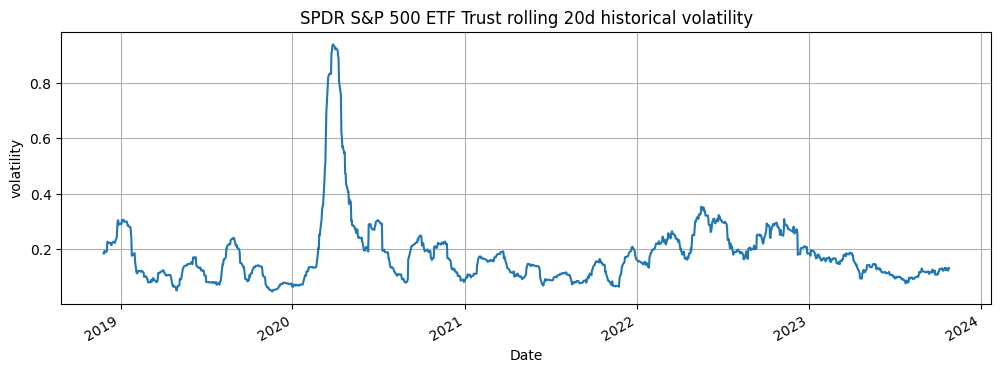

In [7]:
# rolling 20d historic volatility
ax = (y.rolling(20).std()).plot(figsize=(12,4),grid=True,title=name+' rolling 20d historical volatility')
ax.set_ylabel('volatility')

b. EWMA volatility model

In [8]:
#EWMA volatility model
vol0 = y[:21].std()
decay = 0.9
ewma_vol = pd.Series(index=y.index)
for i in range(22, len(y.index)):
    ewma_vol.iloc[i] = (1-decay)*y.iloc[i-1]**2 + decay*vol0**2
    vol0 =  ewma_vol.iloc[i]
ewma_vol = np.sqrt(ewma_vol)


Text(0, 0.5, 'volatility')

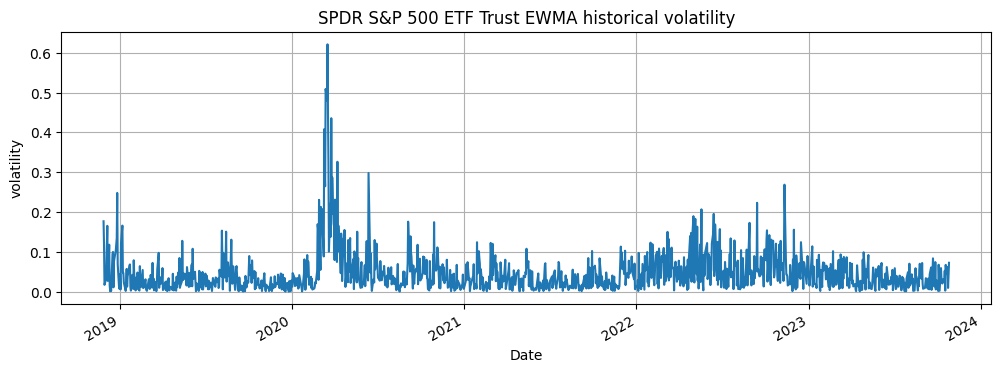

In [9]:
ax = ewma_vol.plot(figsize=(12,4),grid=True,title=name+' EWMA historical volatility')
ax.set_ylabel('volatility')

c. GARCH Model

$y_i=\frac{lnS(t_i)-lnS(t_{i-1})-(\mu-\frac{1}{2}\sigma_i^2)\Delta t}{\sqrt{\Delta t}} \quad \text{follows} \quad N(0,\sigma_i^2)$

$\sigma_{i+1}^2=\kappa\theta+(1-\kappa)[(1-\lambda)y_i^2+\lambda\sigma_i^2]$

In [10]:
import arch
from datetime import datetime

In [11]:
log_rtn = np.log(df.Close/df.Close.shift(1)).dropna()
log_rtn.index = pd.to_datetime(log_rtn.index,utc=True)

In [12]:
# Create a GARCH model and fit it to the data
model = arch.arch_model(log_rtn, vol='GARCH', p=1, q=1 , rescale=False)

split_date = log_rtn.index[-5]
res = model.fit(last_obs=split_date)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6.320134732987826e+20
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4.64253363173266e+18
Iteration:      3,   Func. Count:     32,   Neg. LLF: 95824147912.87387
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1.1616006224766206e+23
Iteration:      5,   Func. Count:     62,   Neg. LLF: 2.63160907186341e+17
Iteration:      6,   Func. Count:     75,   Neg. LLF: 1674322984212.077
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3933.577506516207
            Iterations: 9
            Function evaluations: 82
            Gradient evaluations: 6


In [13]:
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3933.58
Distribution:                  Normal   AIC:                          -7859.16
Method:            Maximum Likelihood   BIC:                          -7838.63
                                        No. Observations:                 1252
Date:                Thu, Oct 26 2023   Df Residuals:                     1251
Time:                        23:23:00   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         9.3613e-04  3.671e-06    254.985      0.000 [9.

c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\arch\univariate\base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\arch\univariate\base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
c:\Users\Wei\anaconda3\envs\OneDrive\Lib\site-packages\arch\univariate\base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To 

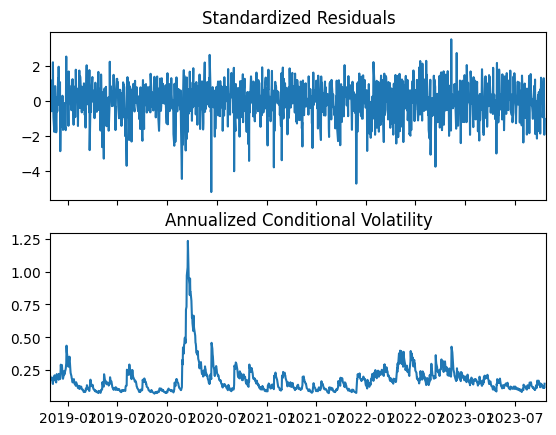

In [14]:
fig = res.plot(annualize="D")

In [15]:
res.forecast(horizon=1).variance**0.5*np.sqrt(252)

,h.1
Date,
2023-10-19 04:00:00+00:00,0.151222
2023-10-20 04:00:00+00:00,0.166354
2023-10-23 04:00:00+00:00,0.151215
2023-10-24 04:00:00+00:00,0.144690
2023-10-25 04:00:00+00:00,0.170855
2023-10-26 04:00:00+00:00,0.163713


In [16]:
kappa = 0.01
theta = 0.04
dacay = 0.9

In [17]:
#GARCH volatility model
vol0 = y[:21].std()
garch_vol = pd.Series(index=y.index)
for i in range(22, len(y.index)):
    garch_vol.iloc[i] = kappa*theta+(1-kappa)*((1-decay)*y.iloc[i-1]**2 + decay*vol0**2)
    vol0 =  garch_vol.iloc[i]
garch_vol = np.sqrt(garch_vol)


Text(0, 0.5, 'volatility')

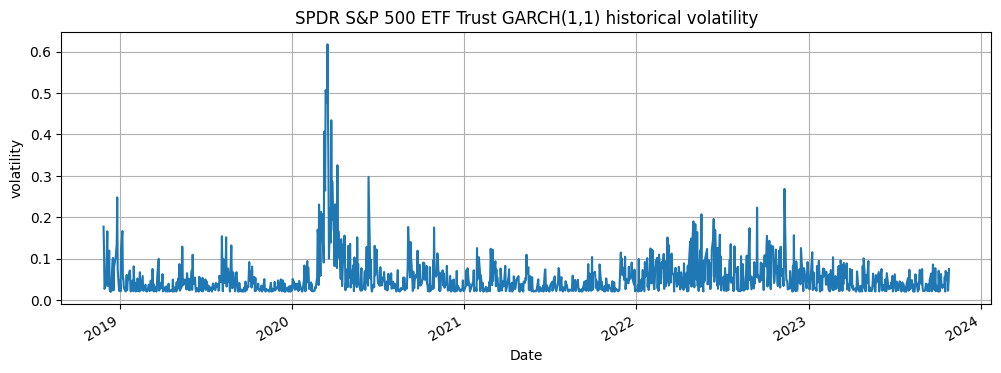

In [18]:
ax = garch_vol.plot(figsize=(12,4),grid=True,title=name+' GARCH(1,1) historical volatility')
ax.set_ylabel('volatility')

<b> 3. <u>Show volatility smile </u></b>

In [19]:
tk = yf.Ticker("SPY")
# Expiration dates
exps = tk.options
# Get options for each expiration
options = pd.DataFrame()
for e in exps:
    opt = tk.option_chain(e)
    opt.calls['optionType'] = 'Call'
    opt.puts['optionType'] = 'Put'
    opt.calls['expirationDate'] = e
    opt.puts['expirationDate'] = e
    
    options = pd.concat([options, pd.concat([opt.calls, opt.puts])])
    

In [20]:
spot = tk.history()["Close"].iloc[-1]

In [21]:
options["Moneyness"] = round(options["strike"]/spot,2)
options = options.set_index("Moneyness")

In [22]:
iv_surface = pd.DataFrame()
for t in exps:
    ivc = options[(options["expirationDate"] == t) & (options["inTheMoney"] == False)].sort_values("strike")["impliedVolatility"]
    adj_ivc = ivc.groupby("Moneyness").mean()
    adj_ivc.name = t
    iv_surface = pd.concat([iv_surface, adj_ivc], axis = 1)

In [23]:
iv_surface.columns = pd.to_datetime(iv_surface.columns)
iv_surface = iv_surface.sort_index()
iv_surface = iv_surface.interpolate(limit_area="inside")

In [24]:
thirdW5 = pd.date_range(exps[0], exps[-1], freq="WOM-3FRI")
thirdW5 = iv_surface.columns.intersection(thirdW5)

In [25]:
name = tk.option_chain().underlying['longName']

Text(0.5, 1.0, 'IV Curve of SPDR S&P 500 ETF Trust')

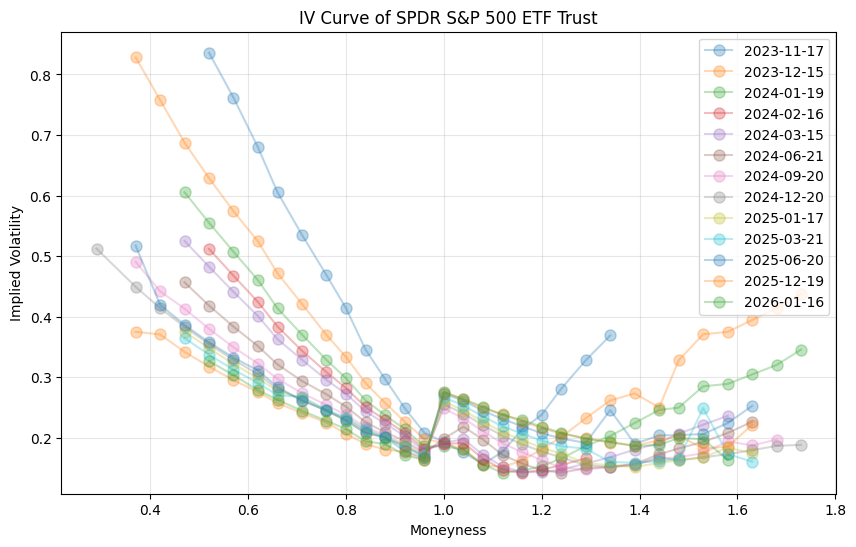

In [32]:
ax = iv_surface.loc[::4,thirdW5].plot(figsize=(10,6), style='-o', alpha = 0.3, ms=8)
ax.grid(alpha = 0.3)
ax.legend(thirdW5.strftime("%Y-%m-%d"), loc=1)
ax.set_xlabel("Moneyness")
ax.set_ylabel("Implied Volatility")
ax.set_title('IV Curve of '+name)

<b> 4. <u>Construct term structure of volatility</u></b>

Text(0.5, 1.0, 'IV Term Structure of SPDR S&P 500 ETF Trust')

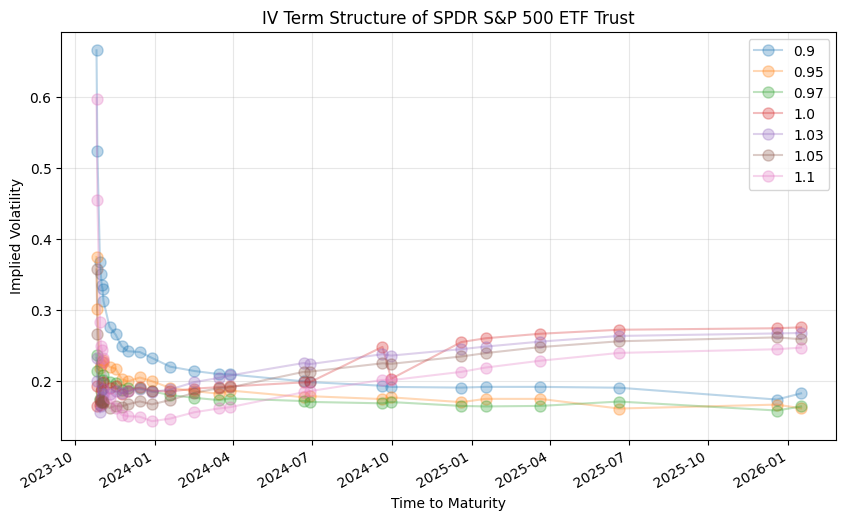

In [27]:
ax = iv_surface.transpose()[[0.9,0.95,0.97,1,1.03,1.05,1.1]].plot(figsize=(10,6), style='-o', alpha = 0.3, ms=8)
ax.grid(alpha = 0.3)
ax.set_xlabel("Time to Maturity")
ax.set_ylabel("Implied Volatility")
ax.set_title('IV Term Structure of '+name)

<b> 5. <u>Plot the volatility surface, as a function of time to maturity and moneyness.</u></b>

In [28]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [29]:
#Singapore time is ahead 1 day to the US time
time2maturity = [((i - datetime.today()).days + 1) / 365 for i in iv_surface[thirdW5].columns]

Text(0.5, 0.92, 'IV Surface of SPDR S&P 500 ETF Trust')

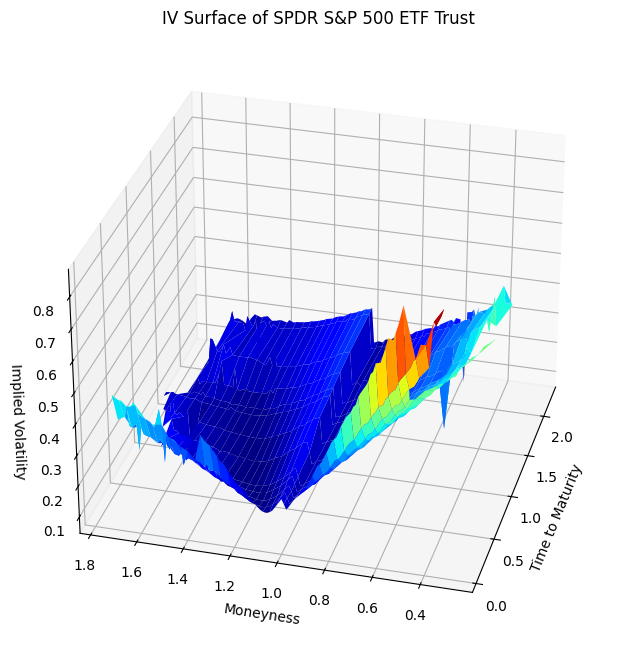

In [30]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(time2maturity, iv_surface[thirdW5].index)
ax.plot_surface(X, Y, iv_surface[thirdW5], cmap=cm.jet, linewidth=0.2)
ax.view_init(30, -165) 
ax.set_xlabel("Time to Maturity")
ax.set_ylabel("Moneyness")
ax.set_zlabel("Implied Volatility")
ax.set_title('IV Surface of '+name)

<b> Question 2: <u>Vanilla European option pricing Use the non-constant volatility model obtained in Question 1(2).</u></b>

Calculate the price of a European call option (whose today’s price can be observed in market) using  

1. Monte Carlo Use the Geometric Brownian motion obtained in Question 1(1). 

Calculate the price of the same European call option using 

2. Numerical PDE
3. Binomial Model 
4. Black-Scholes formula

For each part of 1 to 3, show how accuracy can be improved by increasing computational time. Lastly,  

5. Compare the four calculated prices with the “true price” observed in market. 

Comment on these  methods based on their efficiency and accuracy. Explain any source of error and make 
suggestions on possible ways to reduce the error.

In [43]:
from scipy.stats import norm

In [33]:
tk = yf.Ticker("SPY")

In [36]:
tk.history('5y')

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2018-10-26 00:00:00-04:00,244.628004,249.301240,241.288651,244.085220,201574600,0.0,0.0,0.0
2018-10-29 00:00:00-04:00,247.277355,248.611265,239.043992,242.732895,160749100,0.0,0.0,0.0
2018-10-30 00:00:00-04:00,242.558141,246.651815,242.052162,246.329834,157116000,0.0,0.0,0.0
2018-10-31 00:00:00-04:00,248.979204,251.352641,248.491642,248.960815,128296300,0.0,0.0,0.0
2018-11-01 00:00:00-04:00,249.853189,251.812646,248.730872,251.610260,99495000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2023-10-20 00:00:00-04:00,425.980011,426.540009,421.079987,421.190002,123845800,0.0,0.0,0.0
2023-10-23 00:00:00-04:00,419.609985,424.450012,417.799988,420.459991,92035100,0.0,0.0,0.0
2023-10-24 00:00:00-04:00,422.649994,424.820007,420.739990,423.630005,78564200,0.0,0.0,0.0


In [38]:
opt = tk.option_chain("2023-12-15")

In [41]:
calls = opt.calls

In [44]:
def EuropeanOption(S, K, r, T, sigma, type):
    d1 = (np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if type == 'Call':
        return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)

In [49]:
S0 = 100
K = 100
r = 0.05
T = 1/12
sigma = 0.2


EuropeanOption(S0, K, r, T , sigma, "Call")

2.5120670860398846

In [95]:
num_paths = 10000000
N = 1

stock_price_paths = np.zeros((num_paths, N + 1))
stock_price_paths[:,0] = S0
for i in range(num_paths):
    for t in range(1, N + 1):
        z = np.random.standard_normal(1)
        stock_price_paths[i, t] = stock_price_paths[i, t - 1] * np.exp((r - 0.5 * sigma**2) * T/N + sigma * np.sqrt(T/N) * z)
# pd.DataFrame(stock_price_paths).transpose().plot(legend=False)

C:\Users\Wei\AppData\Local\Temp\ipykernel_25240\2179803733.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  stock_price_paths[i, t] = stock_price_paths[i, t - 1] * np.exp((r - 0.5 * sigma**2) * T/N + sigma * np.sqrt(T/N) * z)


In [96]:
np.mean([max(i - K, 0) for i in stock_price_paths[:,-1] ])*np.exp(-r*T)

2.5141961140432567

In [97]:
np.exp(sigma*pow(T/N,0.5))

1.0594342369612506

In [124]:
N=100
u = np.exp(sigma*pow(T/N,0.5))
d = 1/u
q = (np.exp(r*T/N) - d)/(u - d)
dt = T/N
df = np.exp(-r*T/N)
NodeList = [None]*(N+1)

# Calculation of the payoff of final (Nth) steps Payoff
Ending_Node_Payoff = np.array([(S0*pow(u,i)*pow(d,N-i)) for i in range(N+1)])

# Declaration of a Dynamic array:
#Array(NodePnL) will be used for loop later; the size of the array will decrease by 1 in every loop 
NodePnL = np.maximum(Ending_Node_Payoff - K, 0)

# Save the payoff of last step into NodeList
NodeList[-1] = NodePnL
for i in range(N,0,-1):
    NodePnL=df*(q*NodePnL[1:] + (1-q)*NodePnL[:-1])
    NodeList[i-1] = NodePnL

In [129]:
NodeList[100]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.10542736e-14, 1.16139294e+00,
       2.33627421e+00, 3.52480048e+00, 4.72713020e+00, 5.94342370e+00,
      

In [130]:
import numpy as np

def crank_nicolson(a, y, L, z1, b1, zL, bL):
    # Initialize arrays for c, b, u, and z
    c = np.zeros(L)
    b = np.zeros(L)
    u = np.zeros(L)
    z = np.zeros(L)

    # Set initial values
    u[0] = z1
    b[0] = b1

    # Calculate values for c, b, u, and z
    for j in range(1, L - 1):
        z[j] = a[3] * y[j] + a[1] * y[j + 1] + a[2] * y[j - 1]
        u[j] = (a[2] * u[j - 1] + z[j]) / (a[0] - a[2] * b[j - 1])
        b[j] = a[1] / (a[0] - a[2] * b[j - 1])

    c[L - 1] = (zL + bL * u[L - 1]) / (1 - bL * b[L - 1])

    for j in range(L - 2, 0, -1):
        c[j] = u[j] + b[j] * c[j + 1]

    return c

def euro_call_cranknicolson(S0, K, r, sigma, q, T, N, M, Dist):
    # Define parameters
    dt = T / N
    dx = Dist / M
    dx2 = dx * dx
    u = np.exp(dx)
    
    # Initialize variables
    sig2 = sigma * sigma
    nu = r - q - sig2 / 2
    St = S0 * np.exp(Dist)
    Sb = S0 * np.exp(-Dist)
    a = np.zeros(4)
    a[0] = r / 2 + 1 / dt + sig2 / (2 * dx2)
    a[1] = sig2 / (4 * dx2) + nu / (4 * dx)
    a[2] = a[1] - nu / (2 * dx)
    a[3] = -a[0] + 2 / dt

    # Initialize y array
    L = 2 * M + 1
    y = np.zeros(L)
    
    # Calculate call value at the final date
    S = Sb
    for j in range(L):
        y[j] = max(S - K, 0)
        S *= u

    # Calculate the call value at the penultimate date
    z1 = 0
    b1 = 1
    zL = St - St / u
    bL = 1
    CallV = crank_nicolson(a, y, L, z1, b1, zL, bL)

    # Back up to date 0
    for i in range(N - 2, -1, -1):
        CallV = crank_nicolson(a, CallV, L, z1, b1, zL, bL)

    # Return the value at the middle node
    return CallV[M]
    

In [135]:
euro_call_cranknicolson(S0,K,r,sigma,0, 1/12,100,1000,10)

2.503449653466292

In [622]:
# black scholes PDE numeric solution (explicit scheme)
M = 1000
N = 10000
T = 1/12
tau = 0.5*sigma**2*T
mesh = np.zeros((2*M+1, N+1))
K = 100
S0 = 100
r = 0.05
sigma = 0.2
k = r / (sigma**2/2)
amplitude = 10
dx = amplitude / M
dt = tau / N
L = 2 * M + 1


alpha = dt/(dx**2)

x = np.log(S0*np.exp(amplitude)*np.exp(-dx*np.array(range(L)))/K)
mesh[:, 0] = np.maximum(np.exp(0.5 * (k + 1) * x) - np.exp(0.5 * (k - 1) * x), 0)

mesh[0,:] = mesh[0,0]
mesh[-1,:] = mesh[-1,0]

for t in range(1, N+1):
    mesh[1:-1,t] = alpha*mesh[:-2,t-1] + (1-2*alpha)*mesh[1:-1,t-1] + alpha*mesh[2:,t-1]
    
Cp = (mesh[:,-1]*K*np.exp(-0.5*(k-1)*x-0.25*(k+1)**2*tau))[M]
Cp

2.503506913486421

In [623]:
alpha

0.001666666666666667

Text(0.5, 0, 'Implied Volatility')

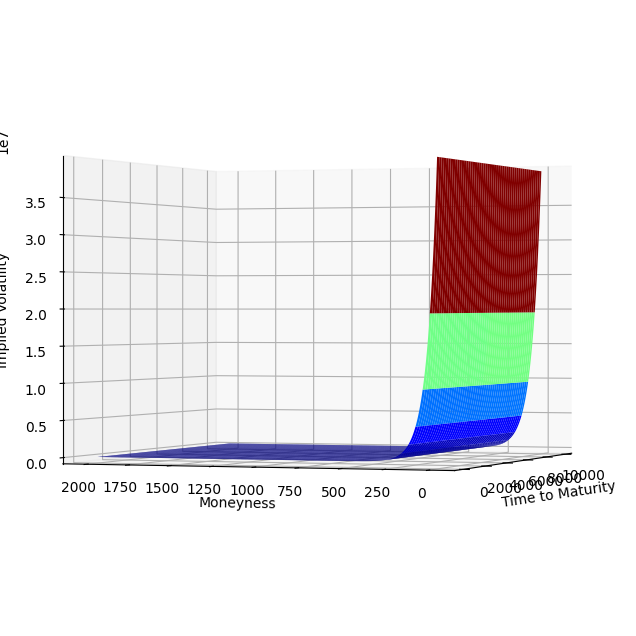

In [624]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(range(mesh.shape[1]), range(mesh.shape[0]))
ax.plot_surface(X, Y, mesh, cmap=cm.jet, linewidth=0.2)
ax.view_init(0, 200) 
ax.set_xlabel("Time to Maturity")
ax.set_ylabel("Moneyness")
ax.set_zlabel("Implied Volatility")
# ax.set_title('IV Surface of '+name)

In [625]:
M_alpha = np.zeros((L-2,L-2))
np.fill_diagonal(M_alpha, 1+2*alpha)
np.fill_diagonal(M_alpha[1:,:], -alpha)
np.fill_diagonal(M_alpha[:,1:], -alpha)

In [626]:
import scipy.linalg

In [627]:
M_alpha_inverse = np.linalg.inv(M_alpha)

In [628]:
# implicit scheme
for t in range(1, N+1):
    boundary = np.zeros((L-2,1))
    boundary[0] = mesh[0,t]
    boundary[-1] = mesh[-1,t] 
    
    b = mesh[1:-1,[t-1]] + alpha*boundary
    mesh[1:-1,[t]] = M_alpha_inverse.dot(b)


In [629]:
(mesh[:,-1]*K*np.exp(-0.5*(k-1)*x-0.25*(k+1)**2*tau))[M]

2.5034500387932606

In [634]:
mesh[1:-1,0] + 0.5*alpha*(mesh[:-2,0] - 2*mesh[1:-1,0] + mesh[2:,0])

array([39132128.87780867, 38453256.20563009, 37786160.58900318, ...,
              0.        ,        0.        ,        0.        ])

In [635]:
(1+alpha)*mesh[1:-1,[1]]-0.5*alpha*(mesh[:-2,[1]]+mesh[2:,[1]])

array([[39132128.86093034],
       [38453256.20560706],
       [37786160.58900804],
       ...,
       [       0.        ],
       [       0.        ],
       [       0.        ]])

In [637]:
C = np.zeros((L-2,L-2))
np.fill_diagonal(C, 1+alpha)
np.fill_diagonal(C[1:,:], -0.5*alpha)
np.fill_diagonal(C[:,1:], -0.5*alpha)

In [639]:
C_inverse = np.linalg.inv(C)

In [640]:
# Crank-Nicolson method
for t in range(1, N+1):
    boundary = np.zeros((L-2,1))
    boundary[0] = mesh[0,t]
    boundary[-1] = mesh[-1,t] 


    Z = mesh[1:-1,[t-1]] + 0.5*alpha*(mesh[:-2,[t-1]] - 2*mesh[1:-1,[t-1]] + mesh[2:,[t-1]])

    b = Z + 0.5*alpha*boundary
    mesh[1:-1,[t]] = C_inverse.dot(b)

In [641]:
(mesh[:,-1]*K*np.exp(-0.5*(k-1)*x-0.25*(k+1)**2*tau))[M]

2.5034784767117273

In [556]:
P, L, U = scipy.linalg.lu(M_alpha)

In [557]:
L

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.33319445e-06,  1.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -8.33319445e-06,  1.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.33319445e-06,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -8.33319445e-06,  1.00000000e+00]])

In [558]:
U

array([[ 1.00001667e+00, -8.33333333e-06,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00001667e+00, -8.33333333e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00001667e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00001667e+00, -8.33333333e-06,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  1.00001667e+00, -8.33333333e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00001667e+00]])